In [1]:
import datetime

In [2]:
import nltk
import string

In [3]:
import pickle

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [7]:
from collections import Counter

In [8]:
from imblearn.under_sampling import RandomUnderSampler

In [9]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [10]:
# function to vectorize the type_of_material series into a y target vector.

def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [11]:
#rate of correct predictions out of total predictions

def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'accuracy = {accuracy}')
    recall = (tp) / (tp + fn)
    print(f'recall = {recall}')
    precision = (tp) / (tp + fp)
    print(f'precision = {precision}')
    print(f'tn:{tn} fp:{fp} fn:{fn} tp:{tp}')

In [12]:
#function that removes string.punctuation w/out the '?'
def punc_strip(string):
    for char in string:
        if char in string.punctuation:
            string = string.replace(char, "")
            
    return string

In [13]:
%%time
#import csv

data = pd.read_csv('/Users/djbetts/Desktop/opinion_classifier/data/us_gov_pol.csv', index_col=0, low_memory=False)

CPU times: user 390 ms, sys: 76.4 ms, total: 466 ms
Wall time: 473 ms


In [14]:
%%time
df = data.copy()

CPU times: user 1.3 ms, sys: 686 µs, total: 1.99 ms
Wall time: 1.65 ms


In [15]:
df.shape

(5816, 21)

In [16]:
df.text.iloc[0]

'WASHINGTON — Federal prosecutors rebuffed a judge’s order to release by Friday highly classified transcripts of discussions that Michael T. Flynn, the president’s former national security adviser, had with the Russian ambassador during the presidential transition.The transcripts between Mr. Flynn and Sergey I. Kislyak, formerly Russia’s top diplomat in the United States, were expected to show that they talked in December 2016 about sanctions that the Obama administration had just imposed on Russia. Mr. Flynn initially denied those exchanges about sanctions both to Trump administration officials and the F.B.I. in the weeks after the discussions.The conversations prompted concerns among senior Obama administration officials about whether the Trump transition team was flouting norms about holding off on making policy until after taking office. The phone calls were also at the center of the scandal that eventually prompted Mr. Flynn’s ouster just weeks into President Trump’s term.The orde

In [17]:
(df.iloc[0])

abstract                                 The release of transcripts of calls between Pr...
web_url                                  https://www.nytimes.com/2019/05/31/us/politics...
snippet                                  The release of transcripts of calls between Pr...
lead_paragraph                           WASHINGTON — Federal prosecutors rebuffed a ju...
print_section                                                                            A
print_page                                                                              22
source                                                                  The New York Times
multimedia                               [{'rank': 0, 'subtype': 'xlarge', 'caption': N...
headline                                 {'main': 'Justice Dept. Keeps Wiretaps Secret ...
keywords                                 [{'name': 'persons', 'value': 'Flynn, Michael ...
pub_date                                                          2019-06-01T00:32:33+0000

In [18]:
(df.iloc[0])

abstract                                 The release of transcripts of calls between Pr...
web_url                                  https://www.nytimes.com/2019/05/31/us/politics...
snippet                                  The release of transcripts of calls between Pr...
lead_paragraph                           WASHINGTON — Federal prosecutors rebuffed a ju...
print_section                                                                            A
print_page                                                                              22
source                                                                  The New York Times
multimedia                               [{'rank': 0, 'subtype': 'xlarge', 'caption': N...
headline                                 {'main': 'Justice Dept. Keeps Wiretaps Secret ...
keywords                                 [{'name': 'persons', 'value': 'Flynn, Michael ...
pub_date                                                          2019-06-01T00:32:33+0000

In [19]:
df.shape

(5816, 21)

In [20]:
(df.iloc[0])

abstract                                 The release of transcripts of calls between Pr...
web_url                                  https://www.nytimes.com/2019/05/31/us/politics...
snippet                                  The release of transcripts of calls between Pr...
lead_paragraph                           WASHINGTON — Federal prosecutors rebuffed a ju...
print_section                                                                            A
print_page                                                                              22
source                                                                  The New York Times
multimedia                               [{'rank': 0, 'subtype': 'xlarge', 'caption': N...
headline                                 {'main': 'Justice Dept. Keeps Wiretaps Secret ...
keywords                                 [{'name': 'persons', 'value': 'Flynn, Michael ...
pub_date                                                          2019-06-01T00:32:33+0000

In [21]:
#sum(df.type_of_material == "News")

In [22]:
#sum(df.type_of_material == "Op-Ed")

In [23]:
df.shape

(5816, 21)

In [24]:
#define X. X is currently pandas series of unsplit strings

X = df.text

In [25]:
#turn series into list...

corpus = list(X)

In [26]:
# define y as a series of op-ed or news

y = df.type_of_material

In [27]:
y

_id
nyt://article/0ae91997-445f-5dd6-89a6-ea3cf6a550a6     News
nyt://article/033c09be-8081-5ab2-bc5c-8120ee1da253    Op-Ed
nyt://article/95e26508-28f9-507c-8237-f208c7b6ec14     News
nyt://article/230df670-3495-5fab-a8a8-d650cc2d6f06     News
nyt://article/85ca7462-2ada-5c4c-9c4f-e08c833d89d3     News
                                                      ...  
nyt://article/6de8f431-350f-5e06-babb-5fb9bbe9cc30     News
nyt://article/c6d36069-bd5f-5d16-a368-a5b483305b4b    Op-Ed
nyt://article/d92bfe8d-73cf-5d9f-8cb2-923375c97382     News
nyt://article/2c085975-3489-5c75-97e7-8556738b5acb     News
nyt://article/bcc0212f-3e67-5ad7-bc4b-271d5556503d    Op-Ed
Name: type_of_material, Length: 5816, dtype: object

In [28]:
%%time
# vectorize y in to (1, 0) (op-ed, news)

y = vectorize_y_ser(y)

CPU times: user 2.37 ms, sys: 351 µs, total: 2.72 ms
Wall time: 2.57 ms


In [29]:
y.value_counts()

0    4490
1    1326
Name: type_of_material, dtype: int64

In [30]:
y.shape

(5816,)

# remove stop words

# stemming/lemmatization

In [31]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [32]:
%%time
def snowball_tokenize(doc):
    snowball = SnowballStemmer('english')
    return [snowball.stem(word) for word in word_tokenize(doc.lower())]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [33]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [34]:
snowball_test_token = snowball_tokenize(corpus[0])

In [35]:
snowball_test_token

['washington',
 '—',
 'feder',
 'prosecutor',
 'rebuf',
 'a',
 'judg',
 '’',
 's',
 'order',
 'to',
 'releas',
 'by',
 'friday',
 'high',
 'classifi',
 'transcript',
 'of',
 'discuss',
 'that',
 'michael',
 't.',
 'flynn',
 ',',
 'the',
 'presid',
 '’',
 's',
 'former',
 'nation',
 'secur',
 'advis',
 ',',
 'had',
 'with',
 'the',
 'russian',
 'ambassador',
 'dure',
 'the',
 'presidenti',
 'transition.th',
 'transcript',
 'between',
 'mr.',
 'flynn',
 'and',
 'sergey',
 'i.',
 'kislyak',
 ',',
 'former',
 'russia',
 '’',
 's',
 'top',
 'diplomat',
 'in',
 'the',
 'unit',
 'state',
 ',',
 'were',
 'expect',
 'to',
 'show',
 'that',
 'they',
 'talk',
 'in',
 'decemb',
 '2016',
 'about',
 'sanction',
 'that',
 'the',
 'obama',
 'administr',
 'had',
 'just',
 'impos',
 'on',
 'russia',
 '.',
 'mr.',
 'flynn',
 'initi',
 'deni',
 'those',
 'exchang',
 'about',
 'sanction',
 'both',
 'to',
 'trump',
 'administr',
 'offici',
 'and',
 'the',
 'f.b.i',
 '.',
 'in',
 'the',
 'week',
 'after',
 '

# vectorizer

# SNOWBALL tfidf

In [36]:
# %%time
# #create vectorizer

# snow_vectorizer = TfidfVectorizer(#input='content', 
# #                 encoding='utf-8', 
# #                 decode_error='strict', 
#                  strip_accents='ascii', 
#                  lowercase=True, 
# #                 preprocessor=None, 
#                  tokenizer=snowball_tokenize, 
# #                 analyzer='word', 
#                  stop_words='english', 
# #                 token_pattern='(?u)\b\w\w+\b', 
# #                 ngram_range=(1, 1), 
#                  max_df=0.90, 
#                  min_df=0.10, 
#                  max_features=None, 
# #                 vocabulary=None, 
# #                 binary=False, 
# #                 dtype=<class 'numpy.float64'>, 
# #                 norm='l2', 
# #                 use_idf=True, 
# #                 smooth_idf=True, 
# #                 sublinear_tf=False
# )

In [37]:
# %%time
# print(datetime.datetime.now())

# X_snowball = snow_vectorizer.fit_transform(corpus)
# # UserWarning: Your stop_words may be inconsistent with your preprocessing. 

/Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))

<!-- /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent)) -->

# WORDNET tfidf

In [38]:
%%time
#create vectorizer

wordnet_vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
                 strip_accents='ascii', 
                 lowercase=True, 
#                 preprocessor=None, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words='english', 
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 2), 
                 max_df=0.95, 
                 min_df=0.05, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 41 µs


# test, train, split

In [ ]:
#test, train, split

In [40]:
%%time
#test, train, split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# (100935, 563) (33645, 563) (100935,) (33645,)
# CPU times: user 65.7 ms, sys: 16.5 ms, total: 82.2 ms
# Wall time: 81.8 ms

(4362,) (1454,) (4362,) (1454,)
CPU times: user 2.78 ms, sys: 1.05 ms, total: 3.83 ms
Wall time: 2.89 ms


In [41]:
%%time
print(datetime.datetime.now())
X_train =  wordnet_vectorizer.fit_transform(X_train)

2021-01-06 09:41:59.044166


/Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 47.5 s, sys: 614 ms, total: 48.1 s
Wall time: 48.7 s


In [42]:
%%time
print(datetime.datetime.now())

X_test = wordnet_vectorizer.transform(X_test)

2021-01-06 09:42:47.704731
CPU times: user 16.6 s, sys: 169 ms, total: 16.8 s
Wall time: 17 s


In [43]:
vocab = wordnet_vectorizer.vocabulary_

In [44]:
len(vocab)

1537

In [45]:
X_train.shape

(4362, 1537)

In [46]:
X_test.shape

(1454, 1537)

# count vectorizer

In [47]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [48]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 1002), (1, 1002)]
RandomUnderSampler(random_state=0)
CPU times: user 7.49 ms, sys: 2.96 ms, total: 10.5 ms
Wall time: 10.6 ms


# random forest classifier

In [49]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)

2021-01-06 09:43:04.747504
CPU times: user 365 ms, sys: 14.3 ms, total: 379 ms
Wall time: 401 ms


In [50]:
y_pred.shape

(1454,)

### metrics y_pred

In [51]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [52]:
print(y_test.shape)
print(y_pred.shape)

(1454,)
(1454,)


In [53]:
metrics_(tn, fp, fn, tp)

accuracy = 0.9078404401650619
recall = 0.9012345679012346
precision = 0.7411167512690355
tn:1028 fp:102 fn:32 tp:292


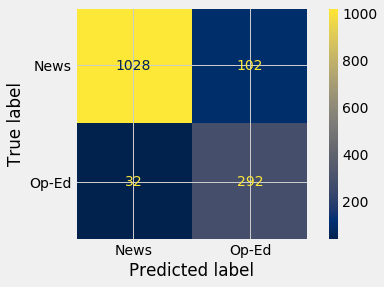

In [54]:
class_names = ["News", "Op-Ed"]

plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                     cmap='cividis');

# important features

### feature imporance

2021-01-06 09:43:05.481133
CPU times: user 379 ms, sys: 16.3 ms, total: 395 ms
Wall time: 407 ms


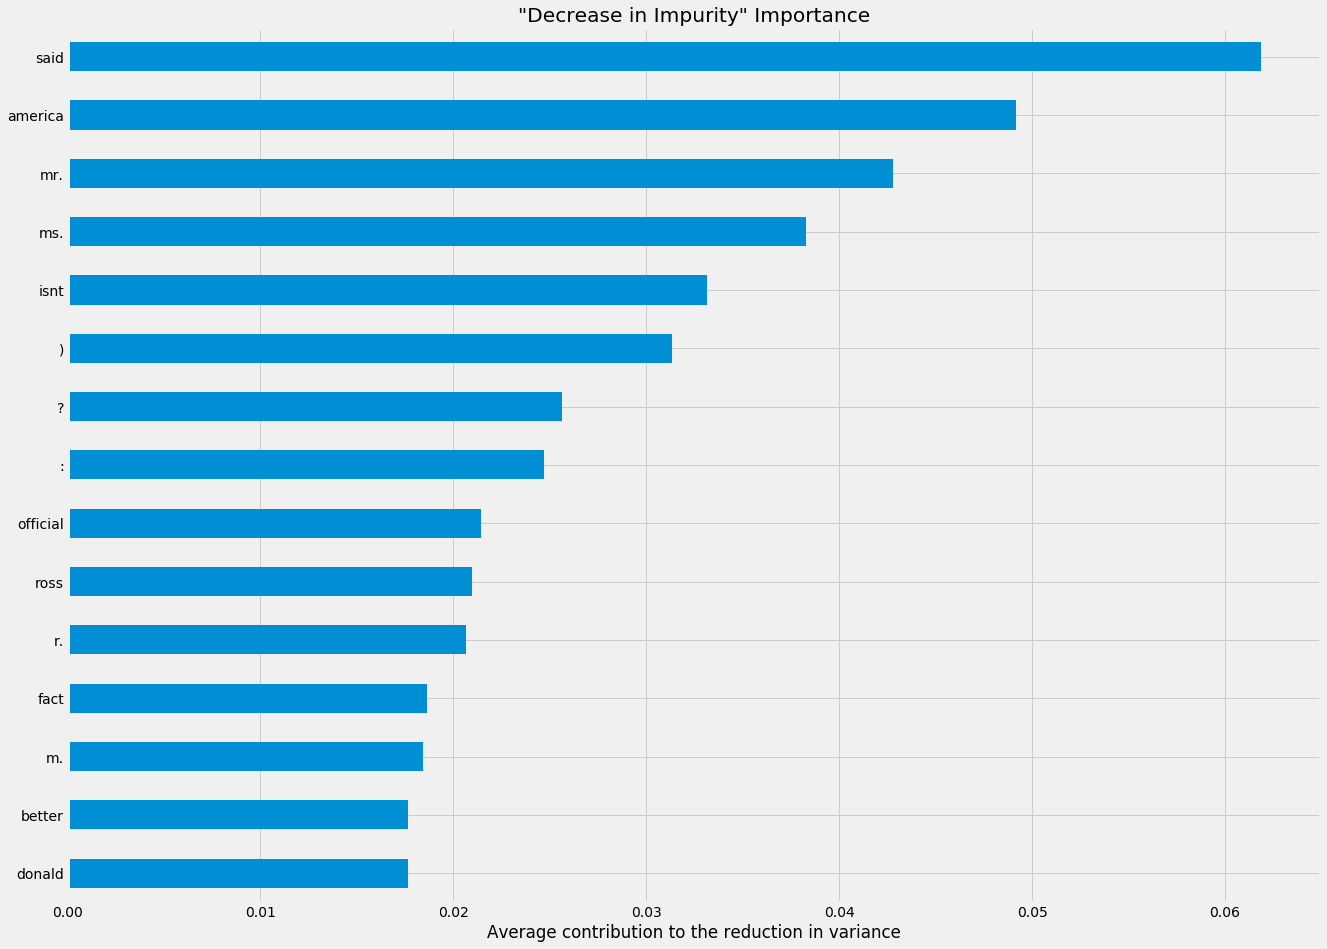

In [55]:
%%time
print(datetime.datetime.now())

feat_names = wordnet_vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import,
                           index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-15:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('important_feat_bar');

### permutation importance

In [ ]:
%%time
print(datetime.datetime.now())
r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feat_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

2021-01-06 09:43:06.453272


In [ ]:
len(feat_names)

In [ ]:
feat_names

In [ ]:
stop_words = wordnet_vectorizer.stop_words_

In [ ]:
len(stop_words)

In [ ]:
wordnet_vectorizer.fixed_vocabulary_

# save model as pickle file

In [ ]:
filename = '/Users/djbetts/Desktop/full_dataset.pkl'

In [ ]:
pickle.dump(rf_clf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#loaded_model.fit(X_resampled, y_resampled)

In [ ]:
result = loaded_model.score(X_resampled, y_resampled)

In [ ]:
type(result)